# Point pixel electrode initialization and simulation

In this notebook we present, how to initialize the arbitrarily-shaped planar trap with electrodes, defined by their boundaries up to the finite resolution. The notebook contains of two different traps, and simulation of ion dynamics in one of it.

In [2]:
from __future__ import division
import pylion as pl
from pathlib import Path
import matplotlib as mpl
import matplotlib.pyplot as plt, numpy as np, scipy.constants as ct
from mpl_toolkits.mplot3d import Axes3D
from electrode import (System, PolygonPixelElectrode, PointPixelElectrode, shaped)

import sion as sn


## Ring trap with dc electrodes

The following trap represents conventional scheme of ring-shaped ion trap with circular RF-electrode, inward grounded electrode, and 4 outer dc electrodes, required for micromotion minimization. First, let's initialize RF drive for capturing of Ca40 ions.

In [3]:
#trap parameters
L = 1  # µm length scale
Vrf = 100.  # RF peak voltage in V
mass = 40 * ct.atomic_mass  # ion mass
Z = 1 * ct.elementary_charge  # ion charge
Omega = 2 * np.pi * 50e6  # RF frequency in rad/s
scale = Z / ((L * Omega) ** 2 * mass)
Urf = Vrf*np.sqrt(Z/mass)/(2*L*Omega)


The point electrode is specialized by it's boundary function of the following form:
 

In [4]:
def boundaries(i, x):
    """
    :param: i: int
    :param: x: tuple (x[0], x[1])
    :return: boolean True or False
    """
    if i == "index of the trap": #specified for the particular electrode with index = i, in desired order 
                                #from i = 0 to i = number of electrodes
            if (x[0]**2+x[1]**2<1): #condition for x=(x,y) point on the x-y plane, representing pixel - 
                                    #in particular this is a circle area with r = 1
                return True  #if it's in the area, bounded by this curve, then we return True
            else:
                return False

The following function specifies, if the point, applied to it, is located within the curves, initializing the desired electrode. Each electrode is assigned with index $i$, ranging from 0 to total number of electrodes, starting from RF electrodes, then dc electrodes. Then each of the electrodes is assigned its voltage and frequency for RF electrodes. If parameters for simulation are required, the param: need_coordinates is set to True. Then, in addition to electrode.System instance, the following parameters are returned:

omegas: list of frequencies of each point in RF electrodes  
trap: list of trap electrode parameters for simulation  
volt: list of voltages of each point for simulation.

The following block sets boundary curves for the ring trap.

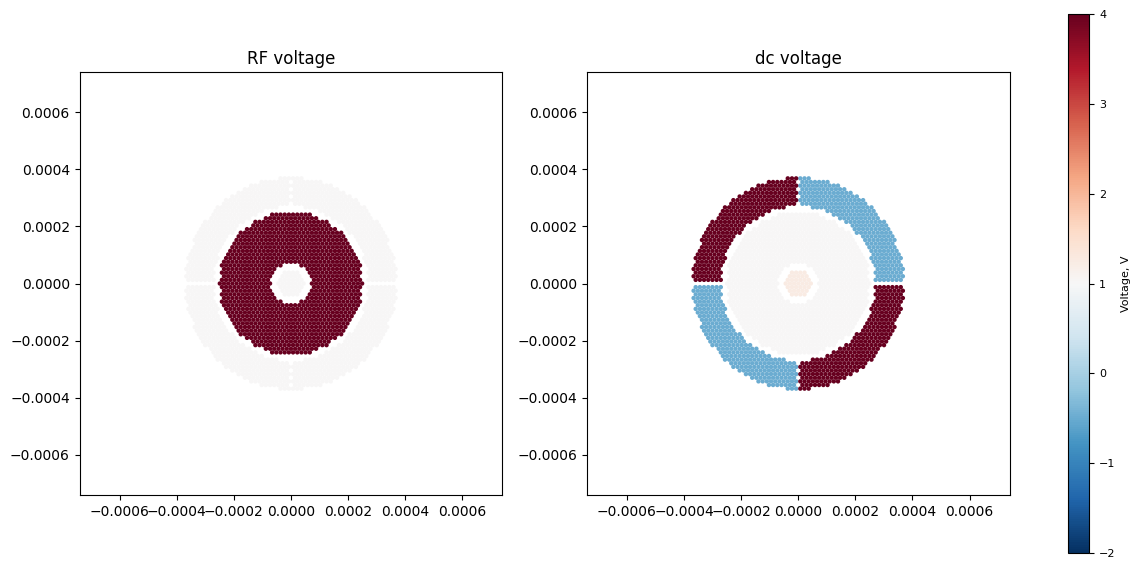

In [5]:
r = 70e-6
R = 250e-6
R_out = 270e-6
sector = 100e-6
r_dc = 50e-6
res = 50
scale = 2*(R_out+sector)
dc_voltages = np.array([0.315, -2, 4, -2, 4])


def boundaries(i, x):
    if i == 0:
        if (x[0]**2+x[1]**2 > r**2) and (x[0]**2+x[1]**2 < R**2):
            return True
        else:
            return False
    elif i == 1:
        if (x[0]**2+x[1]**2 < r_dc**2):
            return True
        else:
            return False
    elif i == 2:
        if (x[0]**2+x[1]**2 > R_out**2) and (x[0]**2+x[1]**2 < (R_out+sector)**2) and (x[0] > 0) and (x[1] > 0):
            return True
        else:
            return False
    elif i == 3:
        if (x[0]**2+x[1]**2 > R_out**2) and (x[0]**2+x[1]**2 < (R_out+sector)**2) and (x[0] < 0) and (x[1] > 0):
            return True
        else:
            return False
    elif i == 4:
        if (x[0]**2+x[1]**2 > R_out**2) and (x[0]**2+x[1]**2 < (R_out+sector)**2) and (x[0] < 0) and (x[1] < 0):
            return True
        else:
            return False
    elif i == 5:
        if (x[0]**2+x[1]**2 > R_out**2) and (x[0]**2+x[1]**2 < (R_out+sector)**2) and (x[0] > 0) and (x[1] < 0):
            return True
        else:
            return False
    

s = sn.point_trap_design(frequencies = [Omega], rf_voltages = [Urf], dc_voltages = dc_voltages, boundaries = boundaries, 
                         scale = scale, resolution = res, need_plot = True, figsize = (15,7))



The following block demonstrates simple analysis of the trap - it's trapping point, secular frequencies of Ca ion, potential distribution above the plane in cross-section of the trapping point.

In [6]:
with s.with_voltages(dcs=0*s.dcs, rfs=None):
    # Check if the minimum was shifted
    x0 = s.minimum([0,0, 90.05e-6], axis=(0, 1, 2), coord=np.identity(3), method="Newton-CG")
    print(f'RF potential minimum: {np.round(x0*1e6, 2)} um')

with s.with_voltages(dcs=None, rfs=None):
    # Check if the minimum was shifted
    x = s.minimum(x0*1.001, axis=(0, 1, 2), coord=np.identity(3), method="Newton-CG")
    print(f'Potential minimum: {np.round(x*1e6, 2)} um')
    print('Distance from RF minimum:', np.round(1e6*(x-x0), 3), 'um')
    # Get trap frequencies
    try:
        curv_z, mod_dir = s.modes(x, sorted=False)
        omega_sec = np.sqrt(Z * curv_z / mass) / (L * 2 * np.pi) * 1e-6
        print("Secular frequencies: (%.4g, %.4g, %.4g) MHz" % (omega_sec[0], omega_sec[1], omega_sec[2]))
        print("In directions \n", mod_dir)
    except:
        print("secular frequencies not found")

RF potential minimum: [-0.    0.   90.33] um
Potential minimum: [-0.   0.  90.3] um
Distance from RF minimum: [-0.     0.    -0.034] um
Secular frequencies: (2.193, 2.456, 4.884) MHz
In directions 
 [[ 7.08042565e-01  7.06169757e-01  0.00000000e+00]
 [ 7.06169757e-01 -7.08042565e-01  3.86219261e-17]
 [-2.72736362e-17  2.73459676e-17  1.00000000e+00]]


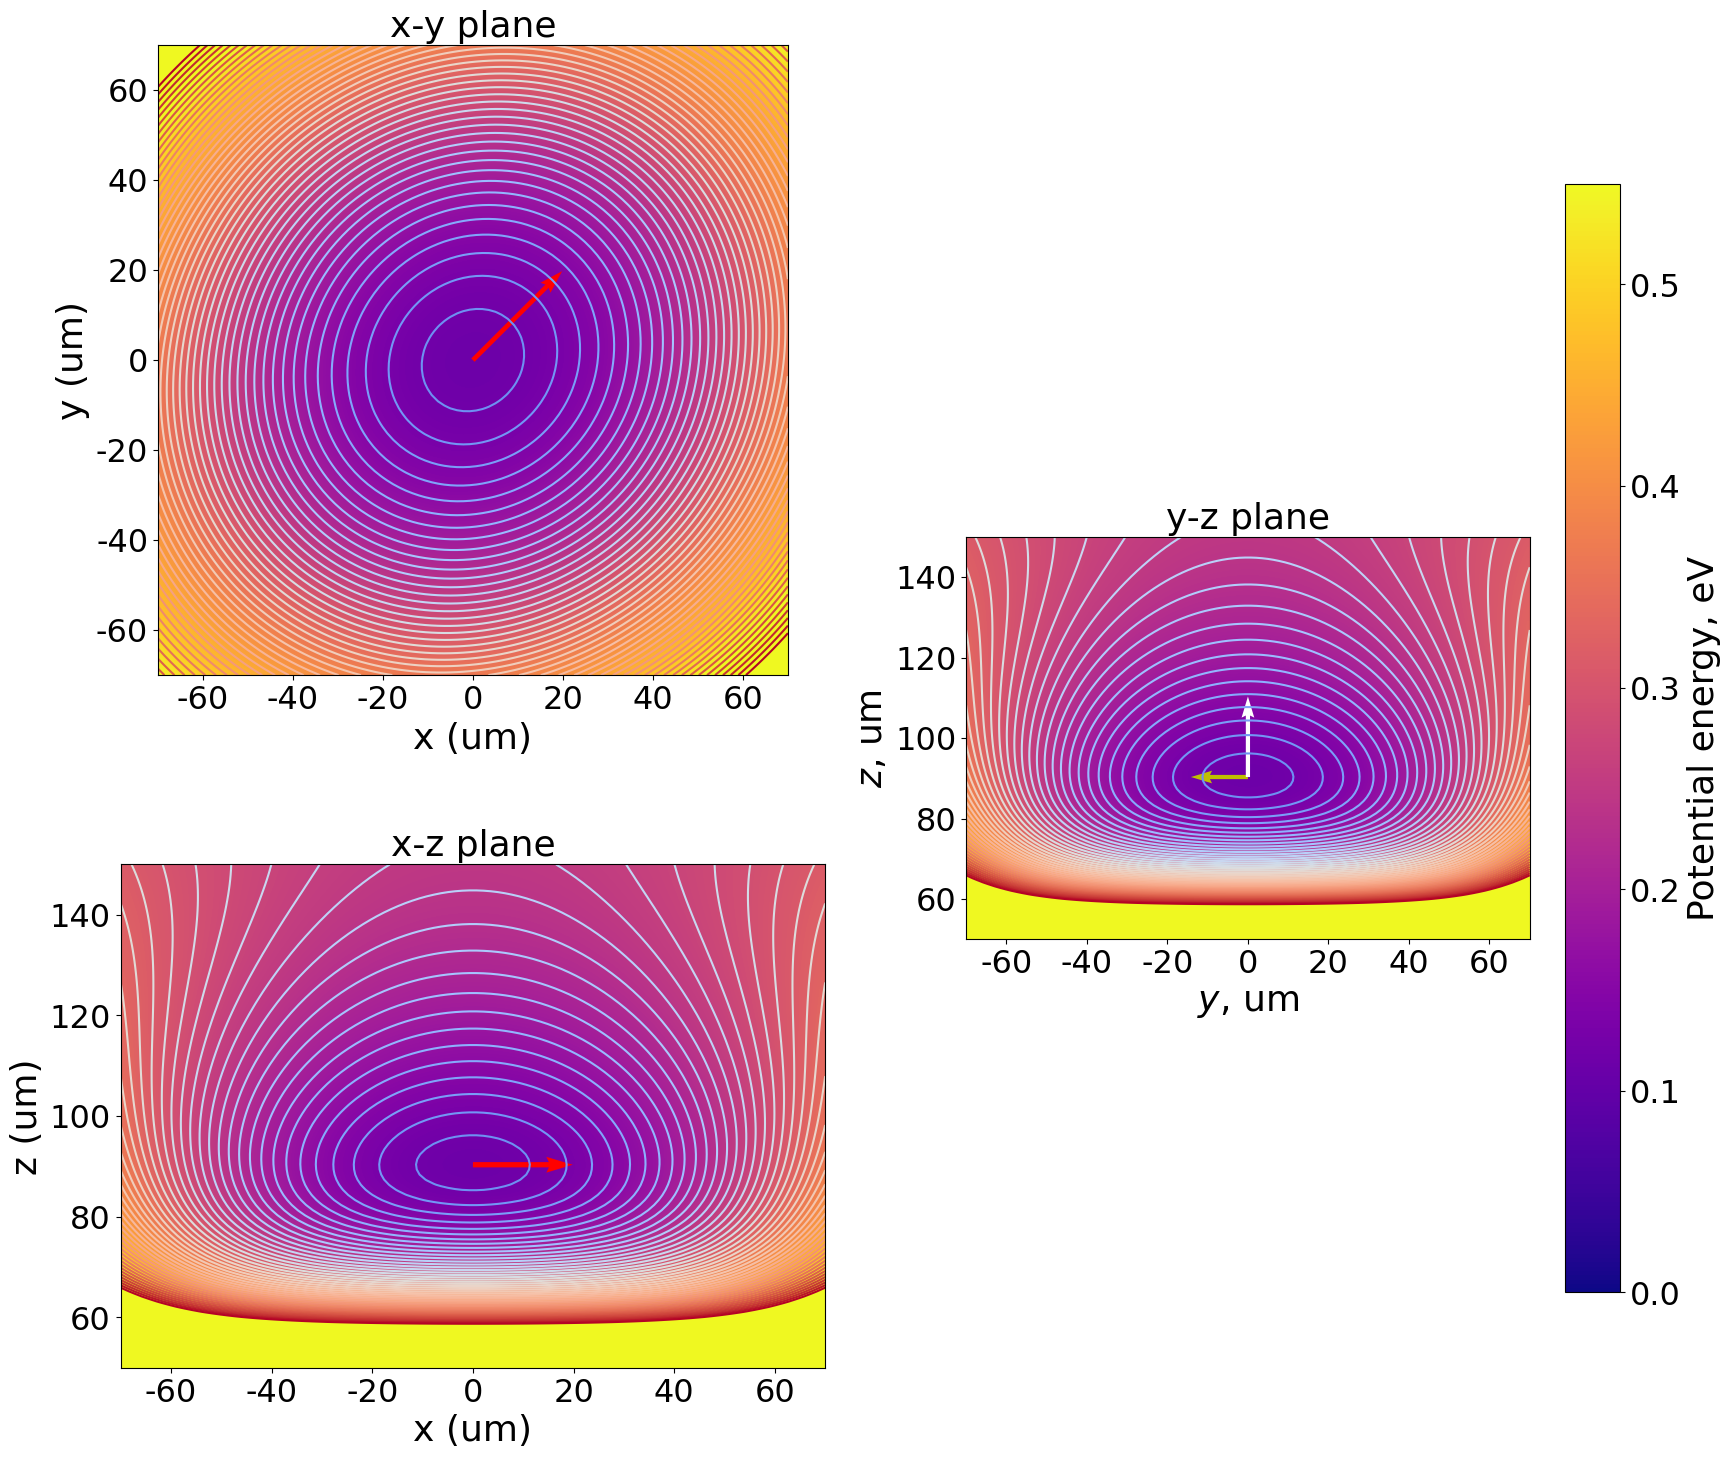

In [7]:

with s.with_voltages(dcs = None, rfs = None):
    # 2D plot settings

    n=100 # resolution of meshgrid = resolution of 2D plots
    xmin, xmax = -70e-6, 70e-6 #set the plot ranges
    ymin, ymax = -70e-6, 70e-6
    zmin, zmax = 50e-6, 150e-6
    x_cut, y_cut, z_cut = x0[0], x0[1], x0[2]# position of the yz-, xz-, xy- crossection
    v = np.arange(0.03,0.6, 0.01)# set the range for contour lines (range in eV)
    v_min, v_max = 0., 0.55 #set the range for colour map (range in eV)
    fs = 26 #set the fontsize
    ls = 23 #set the labelsize
    fig = plt.figure()
    fig.set_size_inches(20,18)

    # x-y cross section
    ax1 = plt.subplot2grid((2,2), (0,0))
    ax1.set_title("x-y plane" ,fontsize=fs)
    ax1.set_xlabel('x (um)',fontsize=fs)
    ax1.set_ylabel('y (um)',fontsize=fs)
    ax1.tick_params(axis='x', labelsize=ls)
    ax1.tick_params(axis='y', labelsize=ls)
    ax1.set_yticks([-60e-6, -40e-6, -20e-6, 0, 20e-6, 40e-6, 60e-6], [-60, -40, -20, 0, 20, 40, 60])
    ax1.set_xticks([-60e-6, -40e-6, -20e-6, 0, 20e-6, 40e-6, 60e-6], [-60, -40, -20, 0, 20, 40, 60])
    xyz = np.mgrid[xmin:xmax:1j*n, ymin:ymax:1j*n, z_cut:z_cut+1]
    pot = shaped(s.potential)(xyz)
    x, y, p = (_.reshape(n, n) for _ in (xyz[0], xyz[1], pot))
    CS=ax1.contour(x, y, p, v, cmap=plt.cm.coolwarm)
    im = ax1.imshow(p.T,cmap='plasma', origin='lower', vmin=v_min, vmax=v_max, extent=(xmin,xmax,ymin,ymax))
    im.set_interpolation('bilinear')

    # x-z cross section
    ax2 = plt.subplot2grid((2,2), (1,0))
    ax2.set_title("x-z plane" ,fontsize=fs)
    ax2.set_xlabel('x (um)',fontsize=fs)
    ax2.set_ylabel('z (um)',fontsize=fs)
    ax2.tick_params(axis='x', labelsize=ls)
    ax2.tick_params(axis='y', labelsize=ls)
    ax2.set_yticks([60e-6, 80e-6, 100e-6, 120e-6, 140e-6], [60 ,80 ,100, 120, 140])
    ax2.set_xticks([-60e-6, -40e-6, -20e-6, 0, 20e-6, 40e-6, 60e-6], [-60, -40, -20, 0, 20, 40, 60])
    xyz = np.mgrid[xmin:xmax:1j*n, y_cut:y_cut+1, zmin:zmax:1j*n]
    pot = shaped(s.potential)(xyz)
    x, z, p = (_.reshape(n, n) for _ in (xyz[0], xyz[2], pot))
    CS=ax2.contour(x, z, p, v, cmap=plt.cm.coolwarm)
    im = ax2.imshow(p.T,cmap='plasma', origin='lower', vmin=v_min, vmax=v_max, extent=(xmin,xmax,zmin,zmax))
    im.set_interpolation('bilinear')

    # y-z cross section
    ax3 = plt.subplot2grid((2,2), (0,1), rowspan=2)
    ax3.set_title("y-z plane" ,fontsize=fs)
    ax3.set_xlabel('$y$, um',fontsize=fs)
    ax3.set_ylabel('$z$, um',fontsize=fs)
    ax3.tick_params(axis='x', labelsize=ls)
    ax3.tick_params(axis='y', labelsize=ls)
    xyz = np.mgrid[x_cut:x_cut+1, ymin:ymax:1j*n, zmin:zmax:1j*n]
    pot = shaped(s.potential)(xyz)
    x, z, p = (_.reshape(n, n) for _ in (xyz[1], xyz[2], pot))
    CS=ax3.contour(x, z, p, v, cmap=plt.cm.coolwarm)
    im = ax3.imshow(p.T,cmap='plasma', origin='lower', vmin=v_min, vmax=v_max, extent=(ymin,ymax,zmin,zmax))
    im.set_interpolation('bilinear') 
    ax3.set_yticks([60e-6, 80e-6, 100e-6, 120e-6, 140e-6], [60 ,80 ,100, 120, 140])
    ax3.set_xticks([-60e-6, -40e-6, -20e-6, 0, 20e-6, 40e-6, 60e-6], [-60, -40, -20, 0, 20, 40, 60])
    # add colorbar
    cb = fig.colorbar(im, ax=ax3, shrink=0.8)
    cb.ax.tick_params(labelsize=ls)
    cb.set_label('Potential energy, eV', fontsize = fs)

    #add secular frequencies
    #change color and scale (the fewer, the longer the arrow)
    ax1.quiver(*[[x0[0]],[x0[1]]], mod_dir[0][0], mod_dir[0][1], color=['r'], scale = 5)
    ax2.quiver(*[[x0[0]],[x0[2]]], mod_dir[0][0], mod_dir[0][2], color=['r'], scale = 5)
    ax3.quiver(*[[x0[1]],[x0[2]]], mod_dir[1][1], mod_dir[1][2], color=['y'], scale = 7)
    ax3.quiver(*[[x0[1]],[x0[2]]], mod_dir[2][1], mod_dir[2][2], color=['w'], scale = 7)

The following block demonstrates the simulation of the trap. The simulation parameters, provided to the simulation function, are obtained through the "need_coordinates = True" parameters. Note: parameters are in stabdard units, so the geometry parameters are in meters (multiplied by L parameter for point centers, L$^2$ for point areas), voltage in V. The simulation is slow due to the complexity of potential function. The faster simulation for research and design purposes may be achieved with lower resolution.

In [75]:
s, trap = sn.point_trap_design(frequencies = [Omega], rf_voltages = [Vrf], dc_voltages = dc_voltages, boundaries = boundaries, 
                               scale = scale, resolution = res, need_coordinates = True)

#insert your path to this file here
name = Path("point_electrode_simulation.ipynb").stem

sim = pl.Simulation(name)

#ion's initialization
ions = {'mass': 40, 'charge': 1}

ion_number = 5
radius = 10e-6
 
positions = sn.ioncloud_min(x0*L, ion_number, radius)    

sim.append(pl.placeions(ions, positions))

#point trap initialization 
#rescaled to meters, for correct simulation
sim.append(sn.point_trap(trap))

#cooling simulation
sim.append(pl.langevinbath(0, 1e-7))

#files with information
sim.append(pl.dump('pos_ring.txt', variables=['x', 'y', 'z'], steps=10))
sim.append(pl.evolve(1e4))
try:
    sim.execute()
except:
    pass

Reducing timestep to 1.5915494309189535e-10 sec
LAMMPS (3 Mar 2020)
OMP_NUM_THREADS environment is not set. Defaulting to 1 thread. (../comm.cpp:94)
  using 1 OpenMP thread(s) per MPI task
Created orthogonal box = (-0.01 -0.01 -0.01) to (0.01 0.01 0.01)
  1 by 1 by 1 MPI processor grid
Created 1 atoms.
Created 1 atoms.
Created 1 atoms.
Created 1 atoms.
Created 1 atoms.
Setting atom values ...
  5 settings made for charge
5 atoms in group 1
5 atoms in group nonRigidBody
Neighbor list info ...
  update every 1 steps, delay 10 steps, check yes
  max neighbors/atom: 2000, page size: 100000
  master list distance cutoff = 11
  ghost atom cutoff = 11
  1 neighbor lists, perpetual/occasional/extra = 1 0 0
  (1) pair coul/cut, perpetual
      attributes: half, newton on
      pair build: half/nsq/newton
      stencil: none
      bin: none
Setting up Verlet run ...
  Unit style    : si
  Current step  : 0
  Time step     : 1.59155e-10
Per MPI rank memory allocation (min/avg/max) = 4.78 | 4.78 |

C:\Users\User_A\anaconda3\Lib\site-packages\pylion-0.5.2-py3.11.egg\pylion\utils.py:95: UserWarning: Caller source not saved. Are you running the simulation from the REPL?
  warnings.warn(


### Trajectory of ions along x and z axes.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


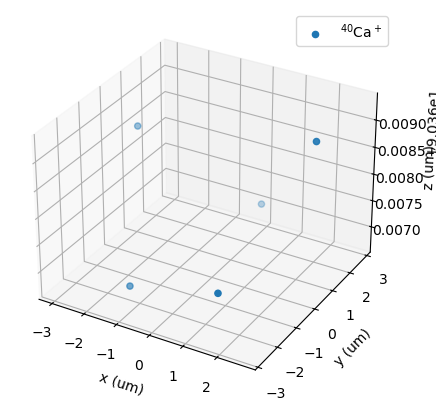

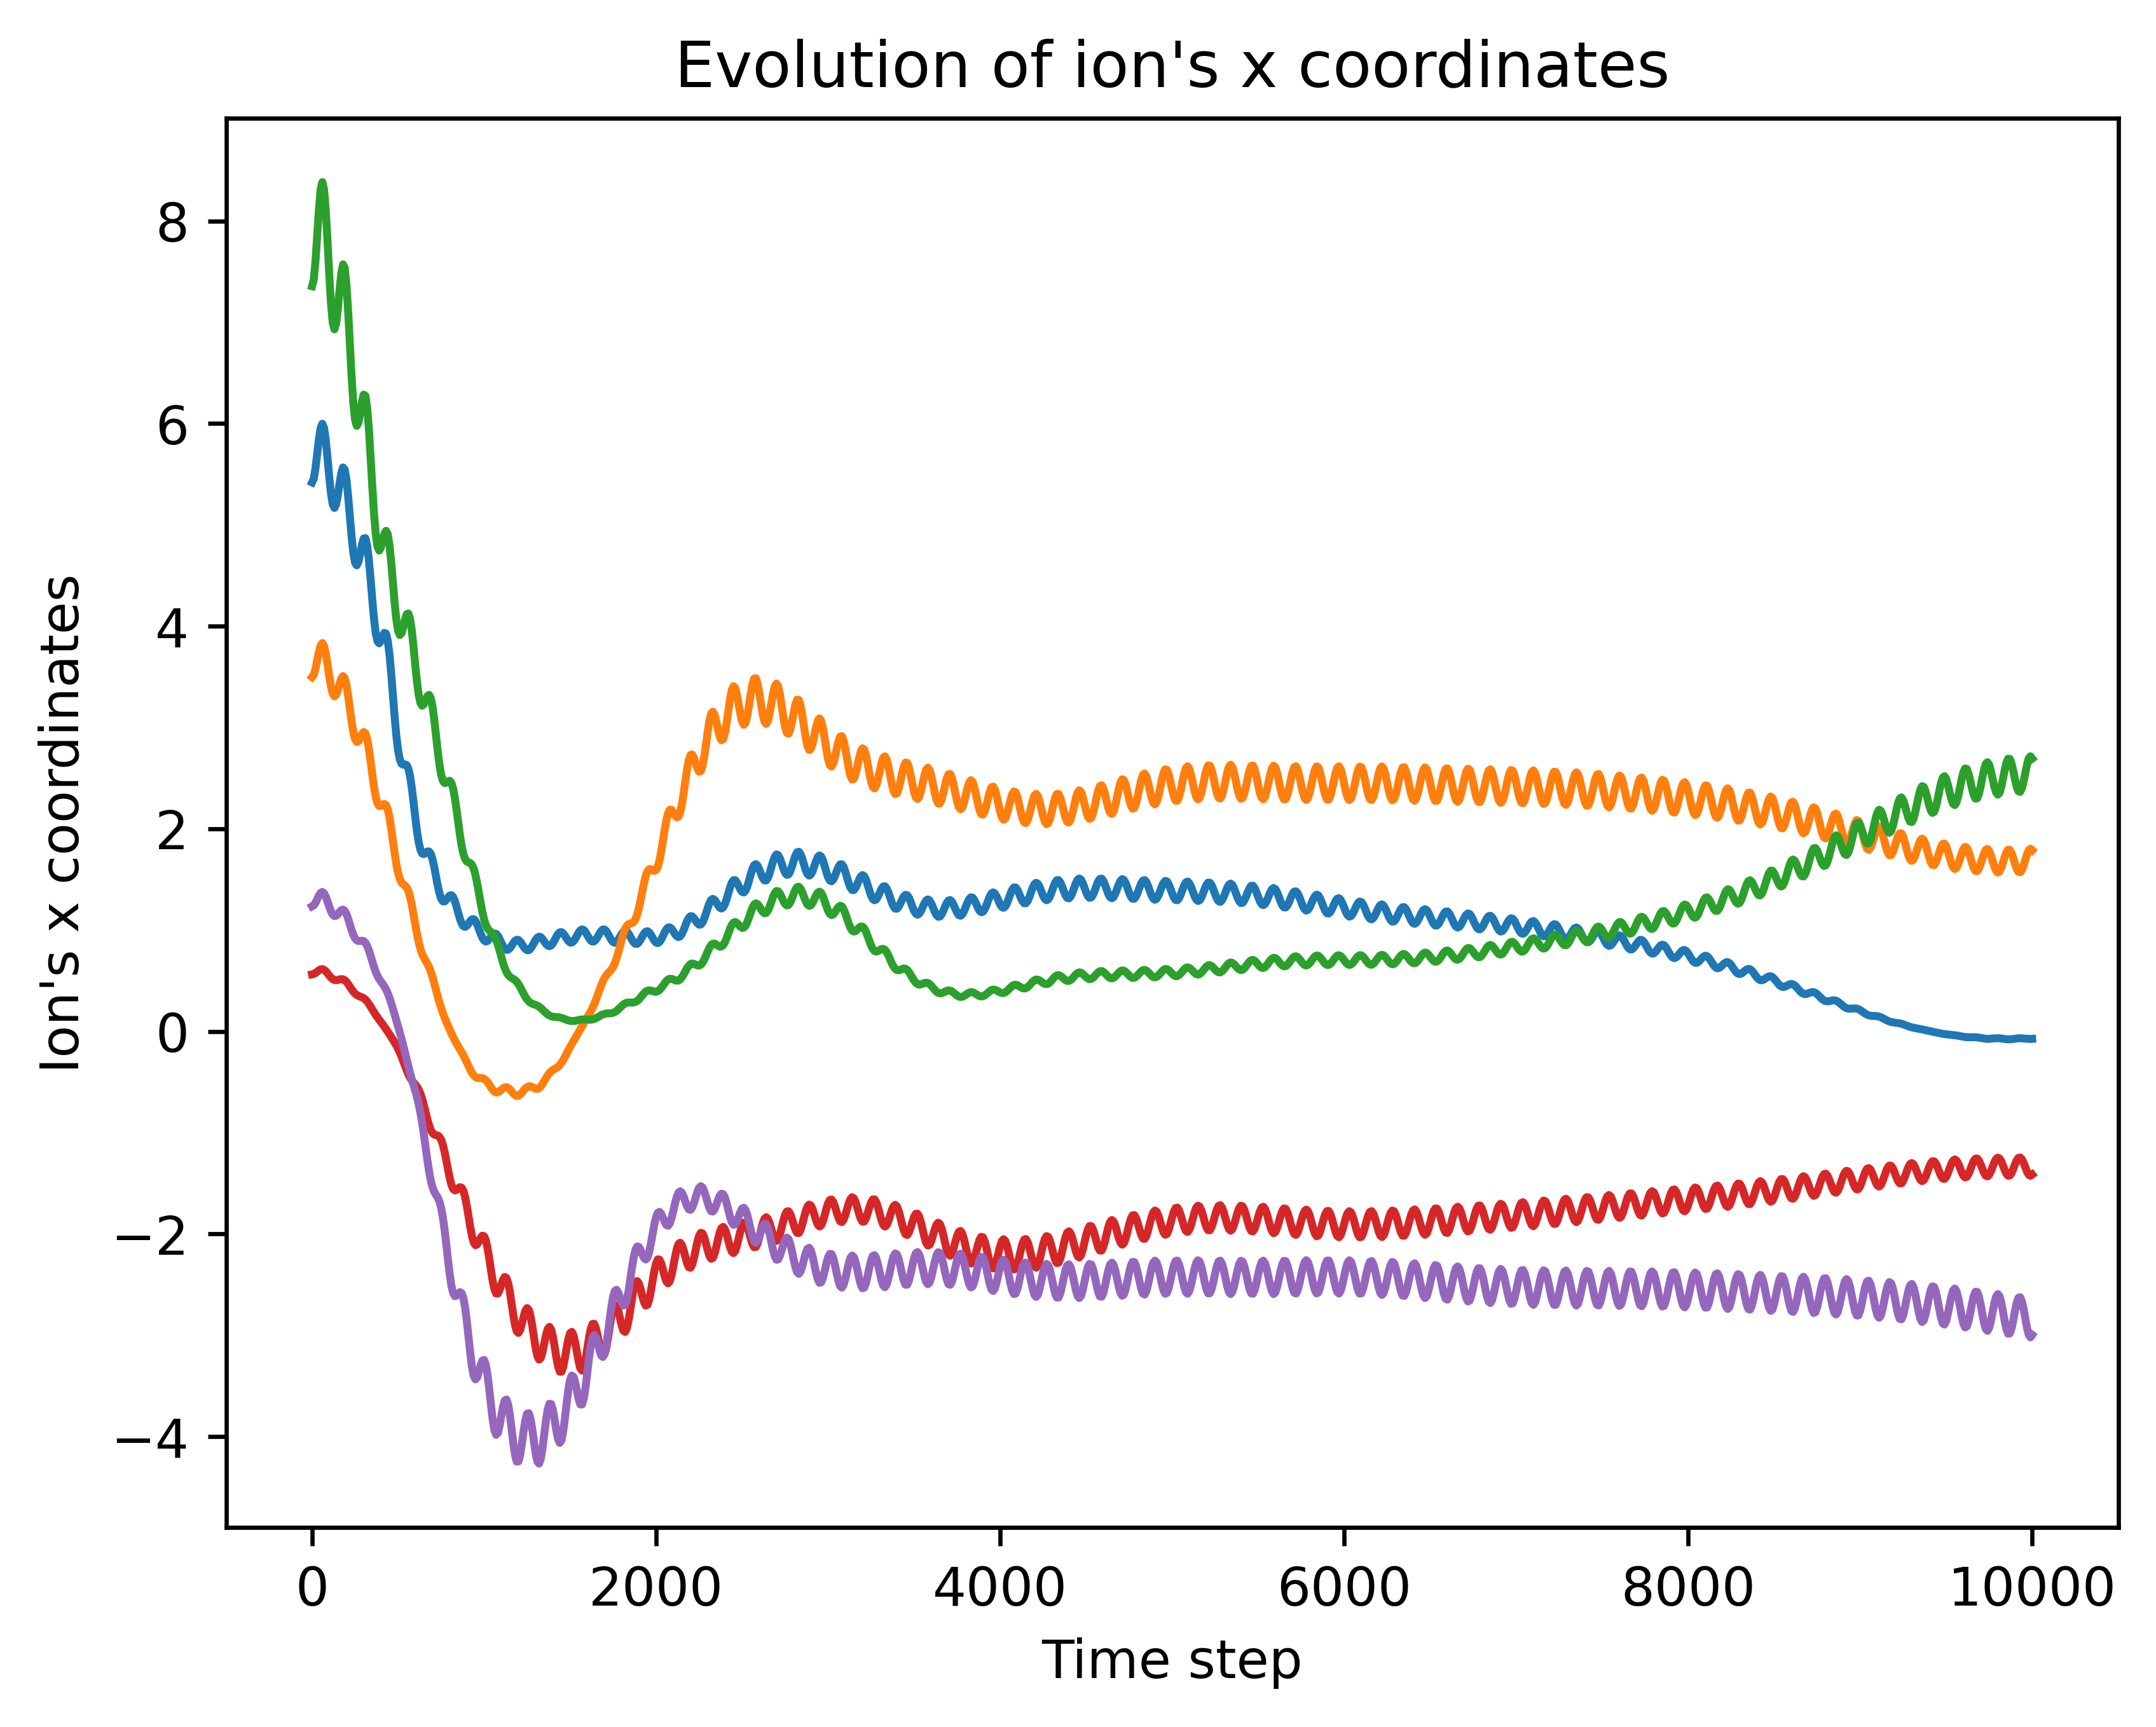

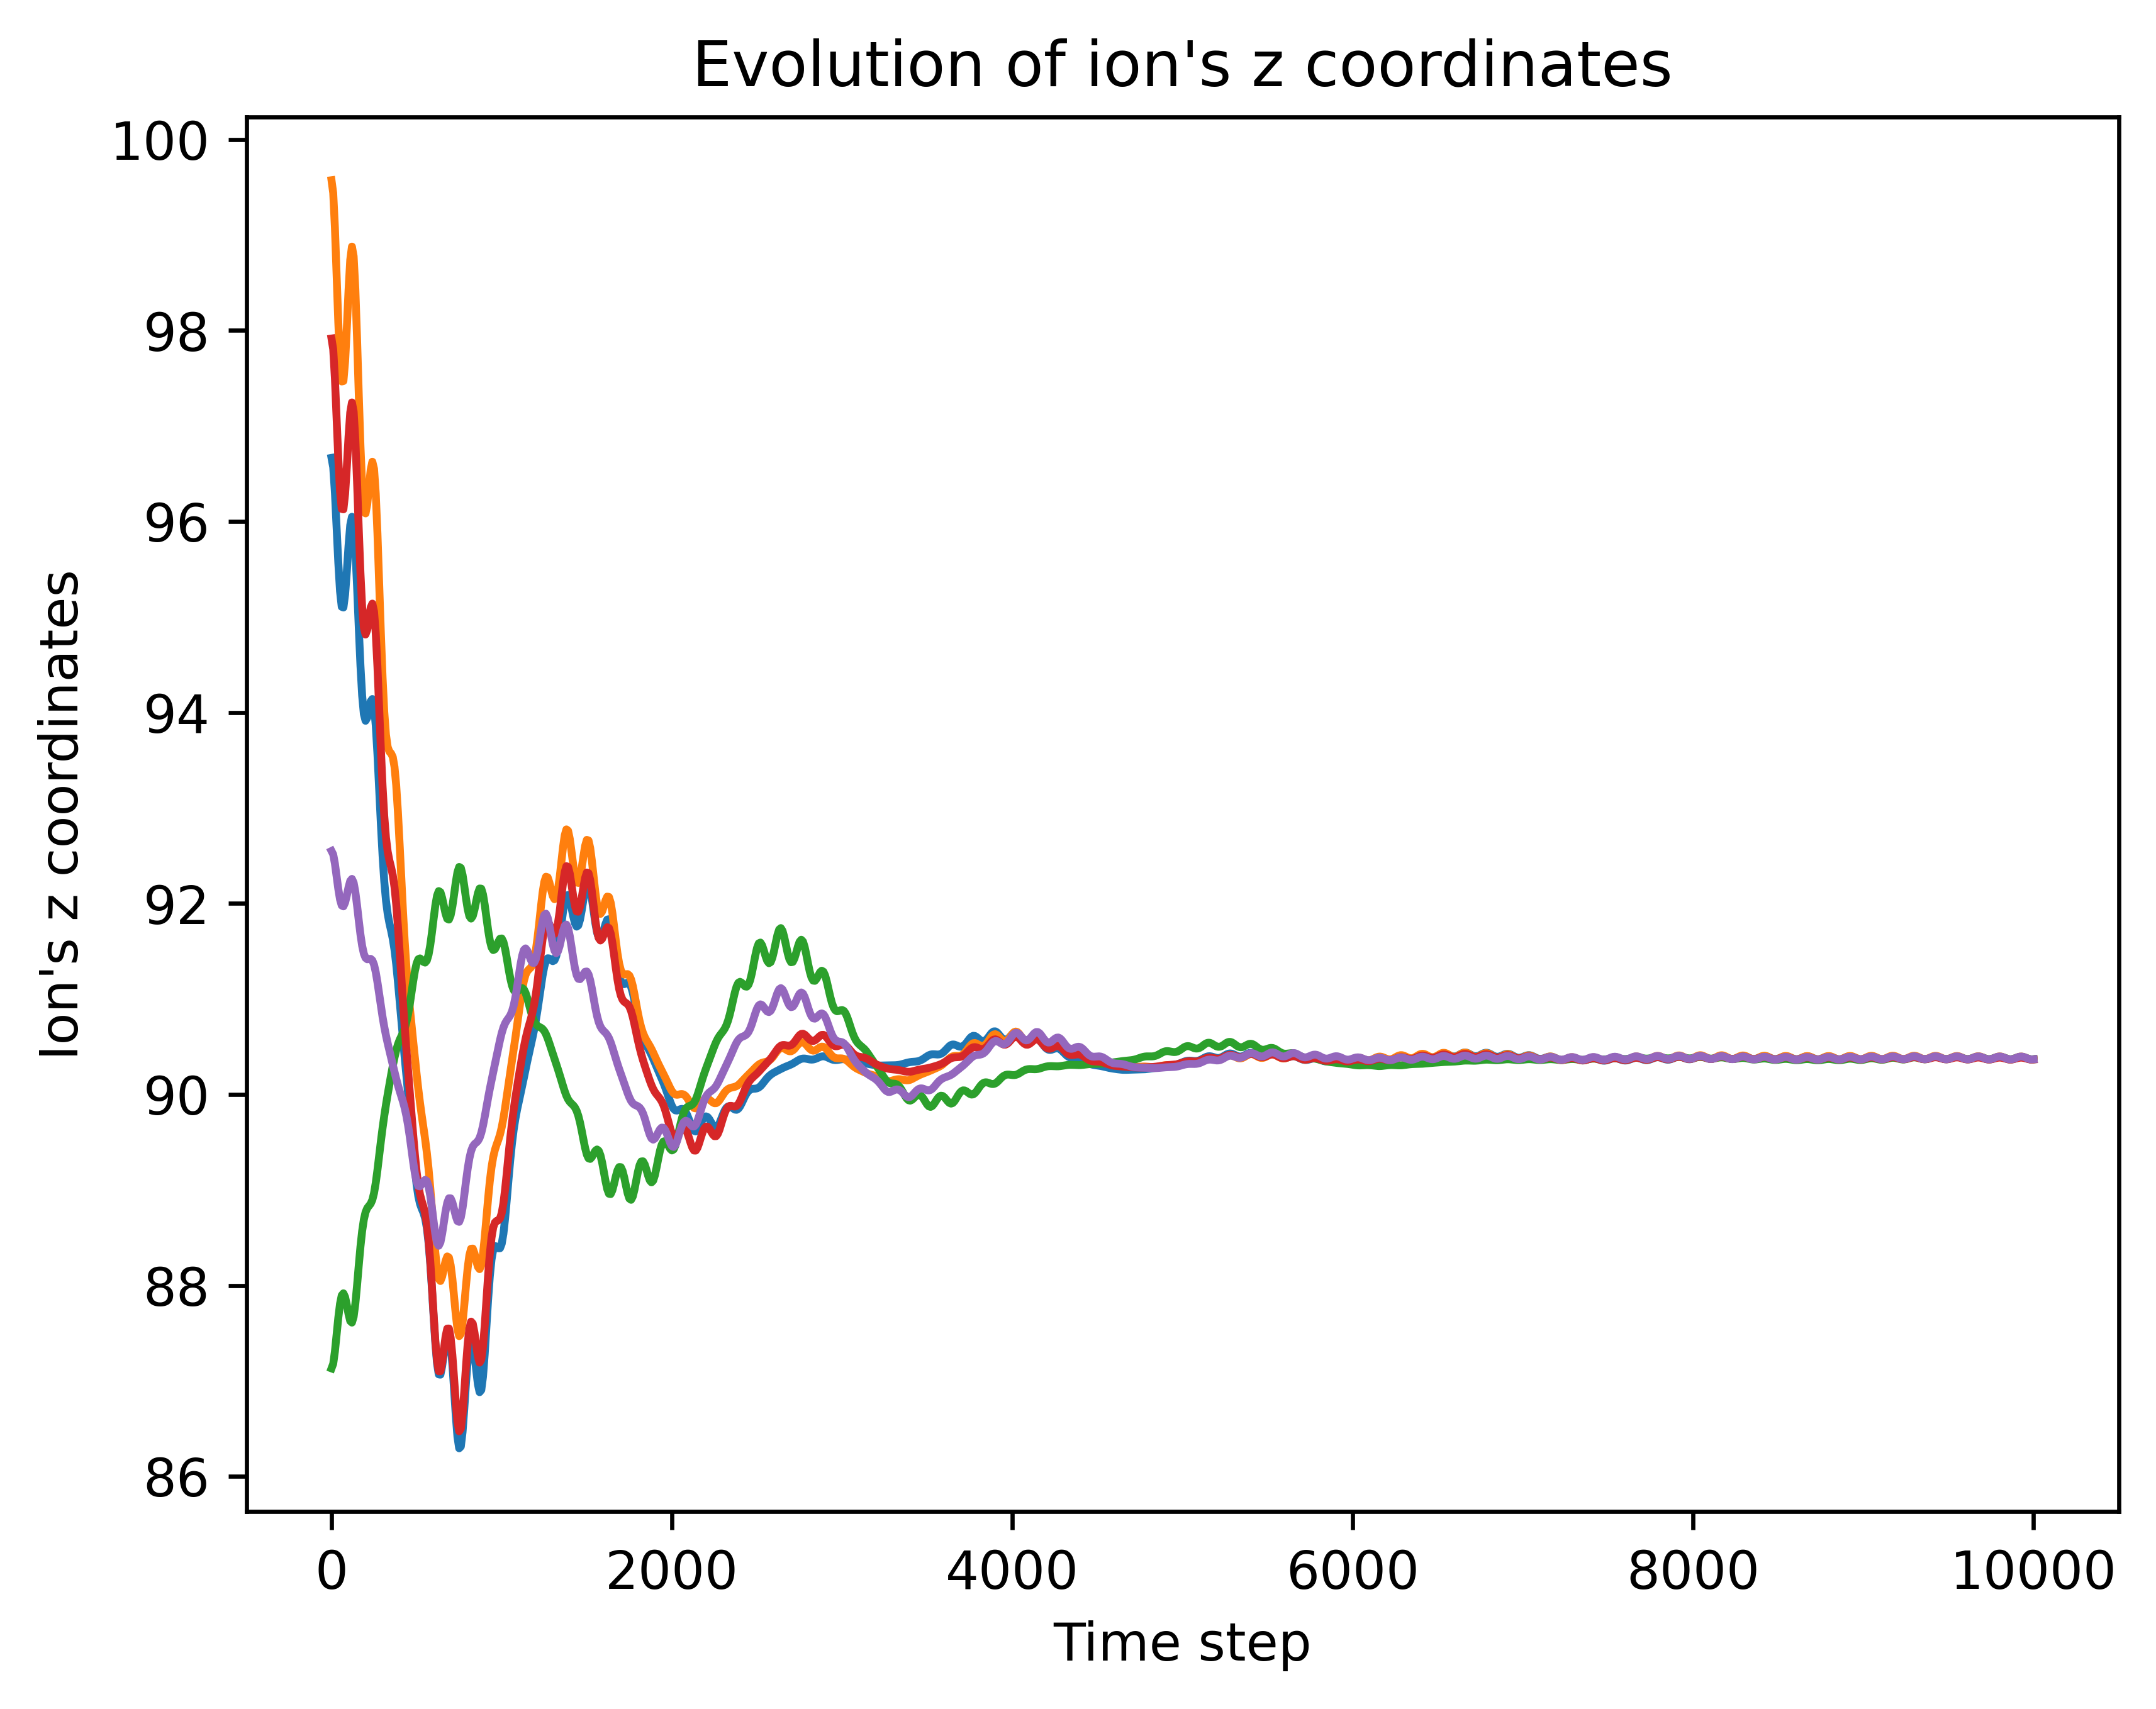

In [76]:
_, data = pl.readdump('pos_ring.txt')
data *= 1e6
ion_number = 5

final_x = data[-1, :, 0]
final_y = data[-1, :, 1]
final_z = data[-1, :, 2]


fig = plt.figure(figsize = [10, 5])
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data[-1, :, 0], data[-1, :, 1], data[-1, :, 2], label = '$^{40}$Ca$^+$')
ax.set_xlabel('x (um)')
ax.set_ylabel('y (um)')
ax.set_zlabel('z (um)')
plt.legend()
plt.savefig('point_electrode_crystal', format = 'eps')
plt.show()


plt.figure(dpi = 600)
for n in range(ion_number):
    plt.plot(np.arange(data.shape[0]) * 10 + 1, data[:, n, 0])
plt.title('Evolution of ion\'s x coordinates')
plt.xlabel('Time step')
plt.ylabel('Ion\'s x coordinates')
plt.show()

plt.figure(dpi = 600)
for n in range(ion_number):
    plt.plot(np.arange(data.shape[0]) * 10 + 1, data[:, n, 2])
plt.title('Evolution of ion\'s z coordinates')
plt.xlabel('Time step')
plt.ylabel('Ion\'s z coordinates')

plt.show()

## Mariia trap: vizualization

The following trap demonstrates, that very unconventional forms of electrodes may be simulated. The following block initializes a heart-shaped RF electrode with an appropriate boundary curve. The surface may be smoother with increase "res" parameter.

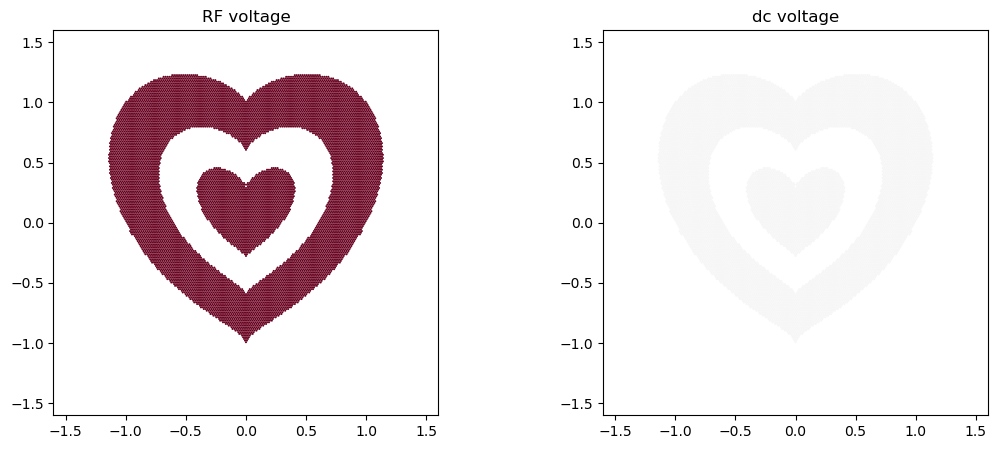

In [64]:
#trap parameters
L = 1e-3  # mm length scale
Vrf = 400.  # RF peak voltage in V
mass = 40 * ct.atomic_mass  # ion mass
Z = 1 * ct.elementary_charge  # ion charge
Omega = 2 * np.pi * 30e6  # RF frequency in rad/s
Urf = Vrf*np.sqrt(Z/mass)/(2*L*Omega)


R = 1
r = 0.6

r_in = 0.3
res = 100

def boundaries(i, x):
    if i == 0:
        if ((x[0]**2 + x[1]**2 - R**2)**3 - x[0]**2*x[1]**3 < 0) and ((x[0]**2 + x[1]**2 - r**2)**3 - x[0]**2*x[1]**3 > 0):
            return True
        else:
            return False
    elif i == 1:
        if ((x[0]**2 + x[1]**2 - r_in**2)**3 - x[0]**2*x[1]**3 < 0):
            return True
        else:
            return False

        
scale = 1.6*R


s, trap = sn.point_trap_design(frequencies = [Omega]*2, rf_voltages = [Urf]*2, dc_voltages = [], boundaries = boundaries,
                               scale = scale, resolution = res, need_coordinates = True, need_plot = True)

### The potential demonstrates a peculiar heart-shaped tube.

RF pseudopotential minimum: 1.703e-29 eV at (1.57e-14, 562, 287)µm
secular frequencies: (0.364, 1.88, 2.244) MHz
in directions
a: [ 1.00000000e+00 -9.98336766e-17 -4.58392137e-17] 
b: [ 3.92392763e-17 -6.51343147e-02  9.97876506e-01] 
c: [-1.02607386e-16 -9.97876506e-01 -6.51343147e-02]


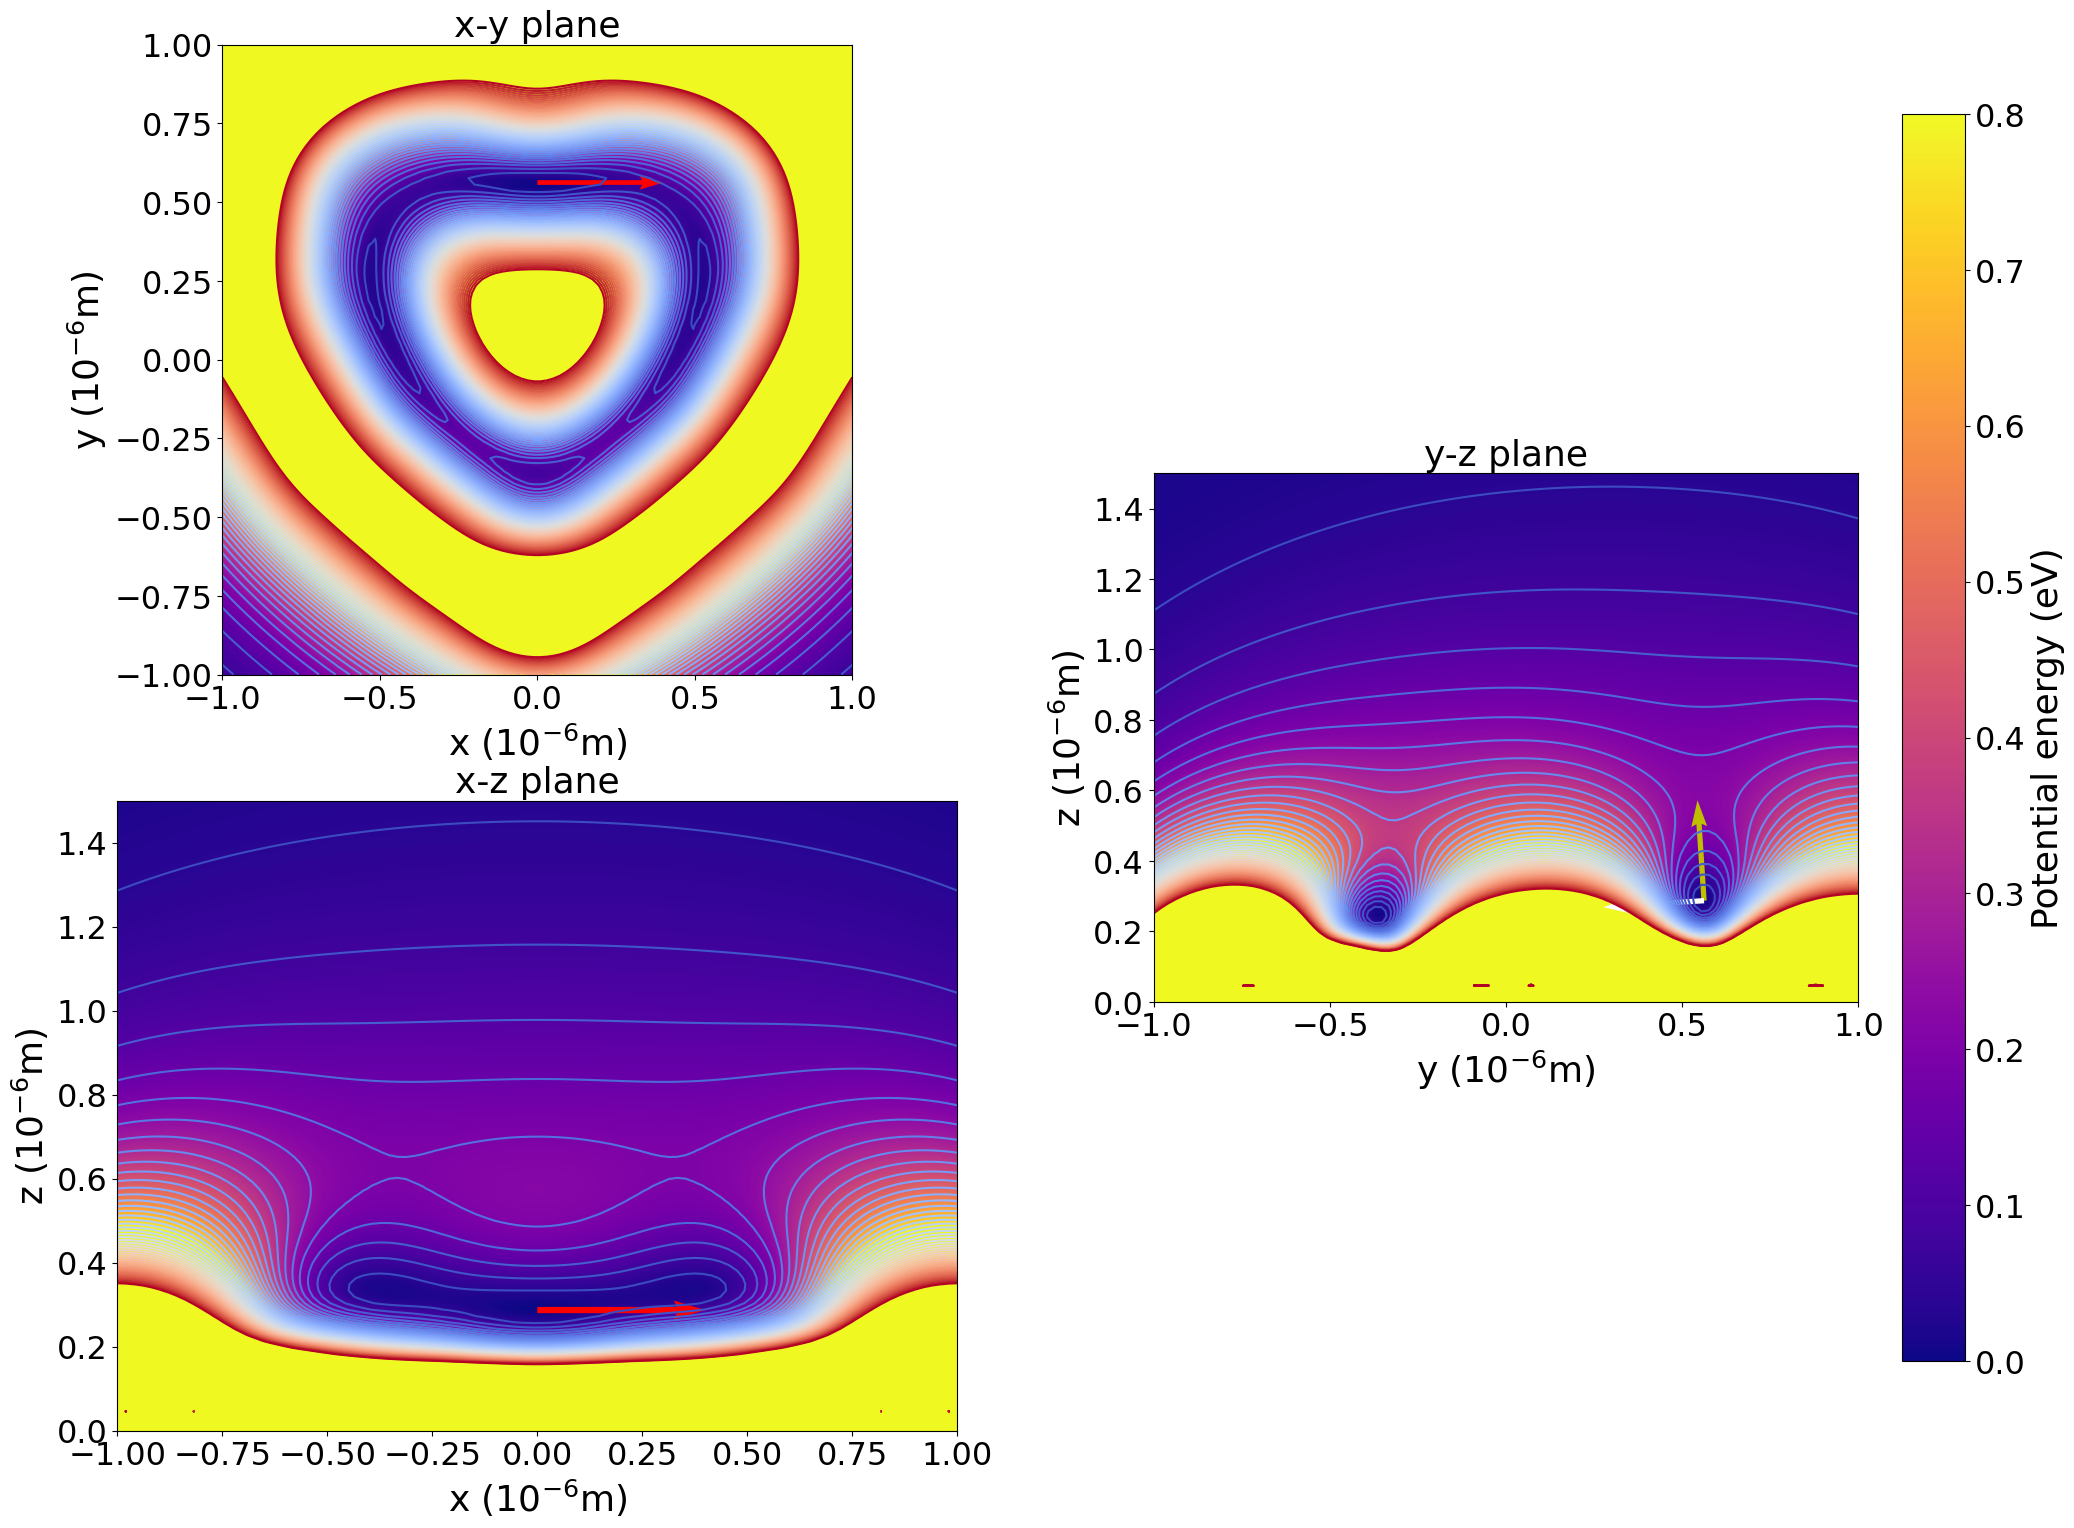

In [69]:
s, trap = sn.point_trap_design(frequencies = [Omega]*2, rf_voltages = [Urf]*2, dc_voltages = [], boundaries = boundaries,
                               scale = scale, resolution = 20, need_coordinates = True, need_plot = False)
with s.with_voltages(dcs = None, rfs = None):
#     try:
    x0 = s.minimum([0, 0.5, 0.1], axis=(0, 1, 2), coord=np.identity(3), method="Newton-CG")
    p_tot0=s.potential(x0, 0)[0]
    print("RF pseudopotential minimum: %.4g" % p_tot0,"eV at (%.3g, %.3g, %.3g)µm" % (x0[0]*L/1e-6, x0[1]*L/1e-6, x0[2]*L/1e-6))
#     except:
#         x0 = x_ini

    curv_z, mod_dir=s.modes(x0,sorted=False)
    omega_sec = np.sqrt(Z*curv_z/mass)/(L*2*np.pi) * 1e-6
    print("secular frequencies: (%.4g, %.4g, %.4g) MHz" % (omega_sec[0],omega_sec[1],omega_sec[2]))
    print("in directions\na:", mod_dir[0],"\nb:", mod_dir[1],"\nc:", mod_dir[2] )
    # in with_voltages, all electrodes have to be listed in an array
    # (the array for dcs also contains the RF electrode)

    # 2D plot settings

    n=100 # resolution of meshgrid = resolution of 2D plots
    xmin, xmax = -1, 1 #set the plot ranges
    ymin, ymax = -1, 1
    zmin, zmax = 0, 1.5
    x_cut, y_cut, z_cut = x0[0], x0[1], x0[2]# position of the yz-, xz-, xy- crossection
    v = np.arange(0.04,2, 0.04)# set the range for contour lines (range in eV)
    v_min, v_max = 0., 0.8 #set the range for colour map (range in eV)
    fs = 26 #set the fontsize
    ls = 23 #set the labelsize
    fig = plt.figure()
    fig.set_size_inches(25,18)

    # x-y cross section
    ax1 = plt.subplot2grid((2,2), (0,0))
    ax1.set_title("x-y plane" ,fontsize=fs)
    ax1.set_xlabel('x ($10^{-6}$m)',fontsize=fs)
    ax1.set_ylabel('y ($10^{-6}$m)',fontsize=fs)
    ax1.tick_params(axis='x', labelsize=ls)
    ax1.tick_params(axis='y', labelsize=ls)
    xyz = np.mgrid[xmin:xmax:1j*n, ymin:ymax:1j*n, z_cut:z_cut+1]
    pot = shaped(s.potential)(xyz)
    x, y, p = (_.reshape(n, n) for _ in (xyz[0], xyz[1], pot))
    CS=ax1.contour(x, y, p, v, cmap=plt.cm.coolwarm)
    im = ax1.imshow(p.T,cmap='plasma', origin='lower', vmin=v_min, vmax=v_max, extent=(xmin,xmax,ymin,ymax))
    im.set_interpolation('bilinear')

    # x-z cross section
    ax2 = plt.subplot2grid((2,2), (1,0))
    ax2.set_title("x-z plane" ,fontsize=fs)
    ax2.set_xlabel('x ($10^{-6}$m)',fontsize=fs)
    ax2.set_ylabel('z ($10^{-6}$m)',fontsize=fs)
    ax2.tick_params(axis='x', labelsize=ls)
    ax2.tick_params(axis='y', labelsize=ls)
    xyz = np.mgrid[xmin:xmax:1j*n, y_cut:y_cut+1, zmin:zmax:1j*n]
    pot = shaped(s.potential)(xyz)
    x, z, p = (_.reshape(n, n) for _ in (xyz[0], xyz[2], pot))
    CS=ax2.contour(x, z, p, v, cmap=plt.cm.coolwarm)
    im = ax2.imshow(p.T,cmap='plasma', origin='lower', vmin=v_min, vmax=v_max, extent=(xmin,xmax,zmin,zmax))
    im.set_interpolation('bilinear')

    # y-z cross section
    ax3 = plt.subplot2grid((2,2), (0,1), rowspan=2)
    ax3.set_title("y-z plane" ,fontsize=fs)
    ax3.set_xlabel('y ($10^{-6}$m)',fontsize=fs)
    ax3.set_ylabel('z ($10^{-6}$m)',fontsize=fs)
    ax3.tick_params(axis='x', labelsize=ls)
    ax3.tick_params(axis='y', labelsize=ls)
    xyz = np.mgrid[x_cut:x_cut+1, ymin:ymax:1j*n, zmin:zmax:1j*n]
    pot = shaped(s.potential)(xyz)
    x, z, p = (_.reshape(n, n) for _ in (xyz[1], xyz[2], pot))
    CS=ax3.contour(x, z, p, v, cmap=plt.cm.coolwarm)
    im = ax3.imshow(p.T,cmap='plasma', origin='lower', vmin=v_min, vmax=v_max, extent=(ymin,ymax,zmin,zmax))
    im.set_interpolation('bilinear') 

    # add colorbar
    cb = fig.colorbar(im, ax=ax3, shrink=0.9)
    cb.ax.tick_params(labelsize=ls)
    cb.set_label('Potential energy (eV)', fontsize = fs)

    #add secular frequencies
    #change color and scale (the fewer, the longer the arrow)
    ax1.quiver(*[[x0[0]],[x0[1]]], mod_dir[0][0], mod_dir[0][1], color=['r'], scale = 5)
    ax2.quiver(*[[x0[0]],[x0[2]]], mod_dir[0][0], mod_dir[0][2], color=['r'], scale = 5)
    ax3.quiver(*[[x0[1]],[x0[2]]], mod_dir[1][1], mod_dir[1][2], color=['y'], scale = 7)
    ax3.quiver(*[[x0[1]],[x0[2]]], mod_dir[2][1], mod_dir[2][2], color=['w'], scale = 7)
    